In [1]:
import numpy as np
from cvxpy import *
import matplotlib.pyplot as plt
import scipy.spatial.distance as sdist
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
%matplotlib inline

In [25]:
def subspace_clustering(problem, ground_truth, set_gamma=0.25, set_K=0, norm_sub=True,
                        plotter=False, printer=False): # factors of 10
    """perform subspace clustering
    keyword arguments:
        problem: to cluster
        ground_truth: of the problem
        gamma: convex factor???
        plotter: plot the problem default=False
        printer: print out statments for debugging default=False
    returns:
        normalized mutual information score
    """
    # load the problem
    X = np.loadtxt(problem)
    if printer: print('problem:\n', X)
        
    # load the ground truth    
    gt = np.loadtxt(ground_truth).astype(np.int32)
    if printer: print('len ground truth:\n', len(gt))
    
    # calculate the nuber of clusters from the ground truth
    nclusters = len(np.unique(gt))
    if printer: print('number of clusters:\n', nclusters)
    
    if plotter:
        if X.shape[1] == 2:
            plt.scatter(X[:,0], X[:,1])
            plt.ylabel('y')
            plt.xlabel('x')
            plt.show()
    
    # transpose X
    A = np.transpose(X)
    if printer: print('A =\n', A)    
    if printer: print('shape of A =', np.shape(A))
        
    # coefficent matrix
    coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
    if printer: print('coeff =\n', coeff)
    
    if printer: print('\n************************************************' +
                      '\n            Solve for coefficents')    
    for i in range(np.shape(A)[1]):
        b = A[:,i]
        if printer: print('b =\n', b)

        # gamma must be positive due to DCP rules.
        # Can change to cvxpy.Parameter
        gamma = Parameter(nonneg="true")
        constraints = None

        # Construct the problem.
        x = Variable(np.shape(A)[1])
        if printer: print('x =\n', x)

        ## Lasso
        obj = Minimize(gamma*norm(A@x-b,2) + norm(x, 1))
        constraints = [x[i] == 0]
        if printer: print(constraints)
        ## constraints = [x[i] == 0, sum(x) == 1]

        ## L1-Perfect
        ## obj = Minimize(norm(x, 1))
        ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
        ## L1-Noisy
        ## obj = Minimize(norm(x, 1))
        ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

        if [constraints == None]:
            prob = Problem(obj)
        else:
            prob = Problem(obj, constraints)

        ## From the original code
        gamma.value = set_gamma
        prob.solve(solver='ECOS')

        coeff[:,i] = np.transpose(x.value)
        if printer: print('coeff =\n', coeff)
            
    if printer: print('\n************************************************' +
                      '\n         Done solving for coefficents\n')

    ## Refine results...
    ## Only use magnitude of the coefficients (no negative values)
    coeff = np.abs(coeff)
    if printer: print('abs of coeff =\n', coeff)
    
#     ## Normalize each row - not needed but doesn't hurt on most examples
#     if norm_sub: coeff = coeff / np.apply_along_axis(np.max,1,coeff)[:,None]
#     if printer: print('norm of coeff =\n', coeff)
        
    ## Symmetrize
    coeff = coeff + np.transpose(coeff)
    if printer: print('symmetrize coeff =\n', coeff)
        
    if set_K == 0:
        K = np.shape(A)[1]
    else:
        if set_K > np.shape(A)[1]:
            print('Max K =', np.shape(A)[1], ', please set K to a lower value.')
        else:
            K = set_K
    if printer: print('K =', K)

    # Select the top K coefficients
    newcoeff = np.zeros(np.shape(coeff))
    if printer: print('newcoeff =\n', newcoeff)
    
    if printer: print('coeff =\n', coeff)
        
    indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,coeff)[:,range(K)]
    if printer: print('indices =\n', indices)

    for x in range(np.shape(coeff)[0]):
        newcoeff[x,indices[x,:]] = coeff[x,indices[x,:]]
    if printer: print('newcoeff =\n', newcoeff)
        
#     # Normalize each row - again, not really needed
#     newcoeff = newcoeff / np.apply_along_axis(np.max,1,newcoeff)[:,None]
#     if printer: print('norm newcoeff =\n', newcoeff)
    
    ## Symmetrize
    newcoeff = newcoeff + np.transpose(newcoeff)
    if printer: print('symmetrize newcoeff =\n', newcoeff)

    ## Standard...
    sub_aff = newcoeff
    
    ## Get row sums
    sub_aff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,sub_aff)))
    if printer: print('sub_aff_D =\n', sub_aff_D)
    
    ## Normalization
    sub_norm = np.matmul(np.matmul(sub_aff_D,sub_aff),sub_aff_D)
    if printer: print('sub_norm =\n', sub_norm)
        
    if norm_sub:
        aff_sub = sub_norm
    else:
        aff_sub = sub_aff
    if printer: print('aff_sub =\n', aff_sub)
        
    #######################################################################
    # plotting the strenghts
#     print(X)
    if plotter:
        if X.shape[1] == 2:
            for i in range(X.shape[0]):
                for j in range(X.shape[0]):
                    if i==j: continue
#                     print(i,j)
#                     print(aff_sub[i,j])
                    if gt[i] == 0:
                        plt.plot(X[[i,j],0],X[[i,j],1], color='red', alpha=aff_sub[i,j])
                    else:
                        plt.plot(X[[i,j],0],X[[i,j],1], color='blue', alpha=aff_sub[i,j])
#                     plt.plot(X[[i,j],0],X[[i,j],1], color='red', alpha=aff_sub[i,j])
            plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in gt])
#             plt.title('Ground Truth: ' + problem )
            plt.title('Subspace Connections' )
            plt.ylabel('y')
            plt.xlabel('x')
            plt.show()
            
    if plotter:
        plt.imshow(aff_sub)
        plt.show()

    # Decomposition
    Evals, Evecs = np.linalg.eigh(aff_sub)
    if printer: print(Evecs)

    if printer: print(Evals[[-1,-2,-3]])
    if plotter:
        plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)
        plt.show()
    
    # Perform clustering
    Xnew = Evecs[:,[-1,-2]]
    if printer: print('Xnew =:', Xnew)
    kmeans = KMeans(n_clusters=nclusters, n_init=10).fit(Xnew)
    if printer: print(kmeans.labels_)

    # If you want to see the eigen vectors...
    if plotter:
        Xone = Evecs[kmeans.labels_==0,:]
        Xtwo = Evecs[kmeans.labels_==1,:]
        plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')
        plt.show()

    if plotter:    
        # If you want it on the PCA projection...
        Xsvd = np.linalg.svd(Evecs)
        Xone = Xsvd[0][kmeans.labels_==0,:]
        Xtwo = Xsvd[0][kmeans.labels_==1,:]
        plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')
        plt.show()

#     ## Let's quantify the performance
#     jointPDF = np.zeros([nclusters,nclusters])
#     for x in range(len(Xassign)):
#         jointPDF[Xassign[x],kmeans.labels_[x]] += 1
#     jointPDF /= len(Xassign)
#     jointPDF += 0.000000000000001
#     marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
#     mut_info = np.sum(jointPDF*np.log2(jointPDF/marginals))
#     print('Mutual Information:', mut_info, 'gamma:', set_gamma)

    nscore = round(normalized_mutual_info_score(gt, kmeans.labels_), 3)*100
    print(problem, 'Normalized Mutual Information Score:', nscore, '%')
    
    # Plot the Subspace clustering attempt at the data
    # Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
    if plotter:
        if X.shape[1] == 2:
            plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
            plt.ylabel('Y')
            plt.xlabel('X')
            plt.show()

problem:
 [[1. 1.]
 [1. 2.]
 [9. 8.]
 [9. 9.]]
len ground truth:
 4
number of clusters:
 2


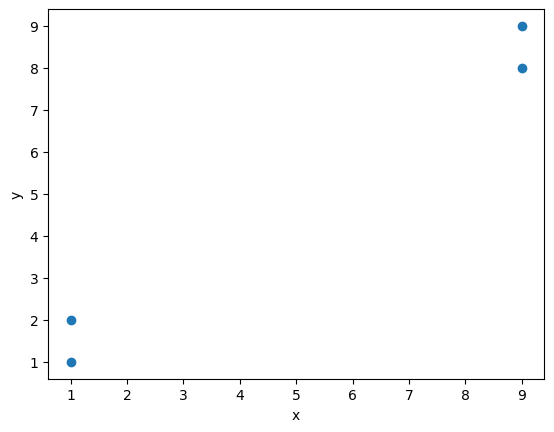

A =
 [[1. 1. 9. 9.]
 [1. 2. 8. 9.]]
shape of A = (2, 4)
coeff =
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

************************************************
            Solve for coefficents
b =
 [1. 1.]
x =
 var467498
[Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ()))]
coeff =
 [[2.86891352e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.88960567e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.27283780e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.11111111e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
b =
 [1. 2.]
x =
 var467541
[Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ()))]
coeff =
 [[2.86891352e-12 2.55190114e-11 0.00000000e+00 0.00000000e+00]
 [4.88960567e-12 8.66908261e-11 0.00000000e+00 0.00000000e+00]
 [1.27283780e-11 4.28265763e-11 0.00000000e+00 0.00000000e+00]
 [1.11111111e-01 1.48275808e-01 0.00000000e+00 0.00000000e+00]]
b =
 [9. 8.]
x =
 var467584
[Equality(Expression(AFFINE, UNKNO

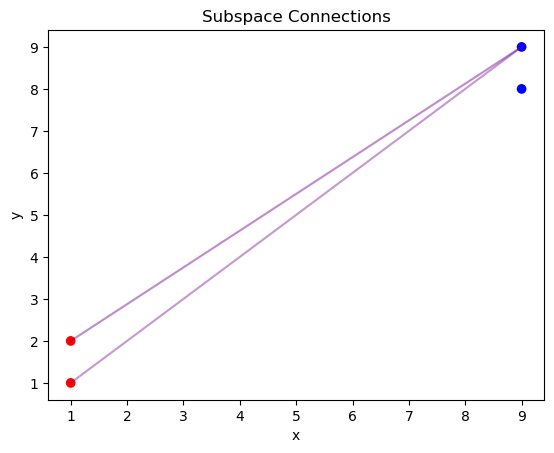

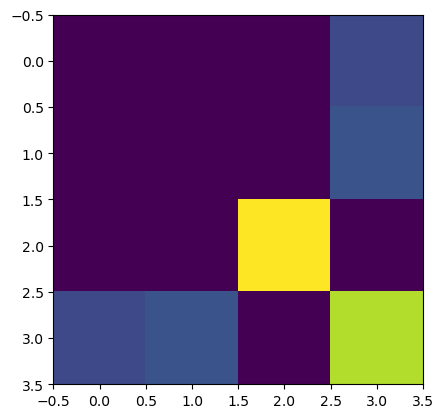

[[-6.19876869e-01  7.56068444e-01  1.39730065e-01  1.56807793e-01]
 [-7.16080472e-01 -6.54492557e-01  1.61415882e-01  1.81144039e-01]
 [ 5.87398898e-11  2.66436303e-11 -7.46592263e-01  6.65281889e-01]
 [ 3.20907191e-01  1.53213316e-09  6.30095560e-01  7.07105480e-01]]
[1.00000000e+00 1.00000000e+00 2.95944252e-10]


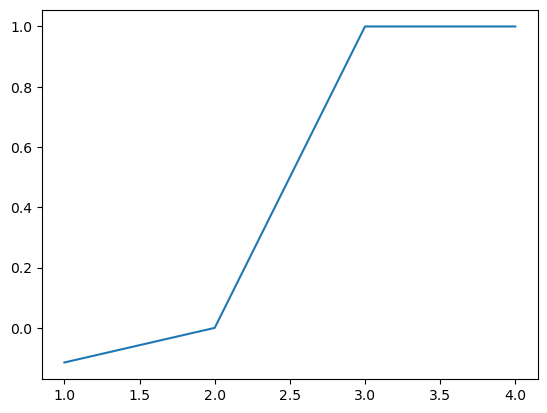

Xnew =: [[ 0.15680779  0.13973006]
 [ 0.18114404  0.16141588]
 [ 0.66528189 -0.74659226]
 [ 0.70710548  0.63009556]]
[0 0 1 0]


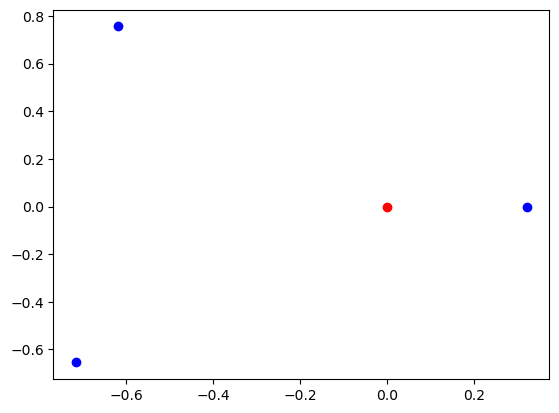

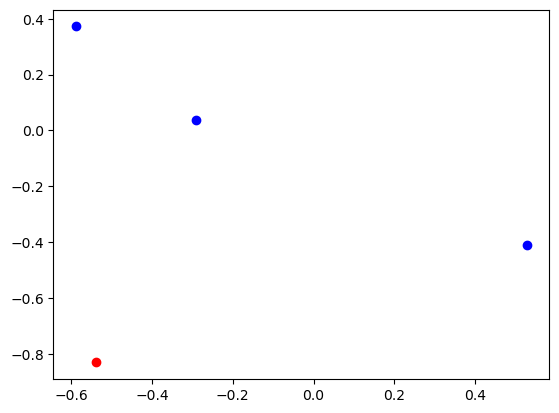

../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %


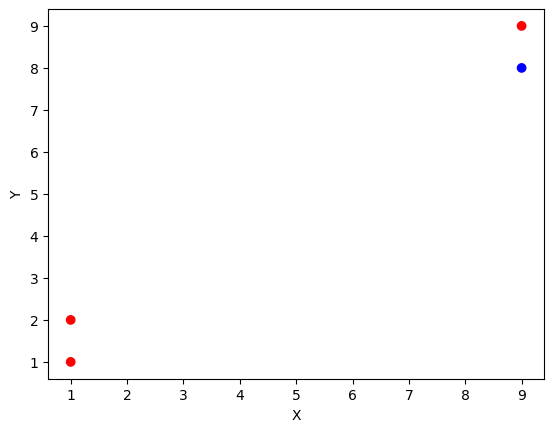

In [26]:
subspace_clustering('../toy_problems/01_simple_two_and_two.tp', '../toy_problems/01_simple_two_and_two_ground_truth.tp', set_gamma=0.25, set_K=0,
                        plotter=True, printer=True)

In [19]:
test = np.linspace(0, 10, num = 50, endpoint = True, retstep = False, dtype = None)

In [20]:
for i in range(len(test)):
    subspace_clustering('../toy_problems/01_simple_two_and_two.tp', '../toy_problems/01_simple_two_and_two_ground_truth.tp', set_gamma=test[i], set_K=0,
                        plotter=False, printer=False)

../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 0.0 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Information Score: 34.4 %
../toy_problems/01_simple_two_and_two.tp Normalized Mutual Informa

In [21]:
for i in range(len(test)):
    subspace_clustering('../toy_problems/10_x.tp', '../toy_problems/03_ground_truth.tp', set_gamma=test[i], set_K=0,
                        plotter=False, printer=False)

../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %
../toy_problems/10_x.tp Normalized Mutual Inform

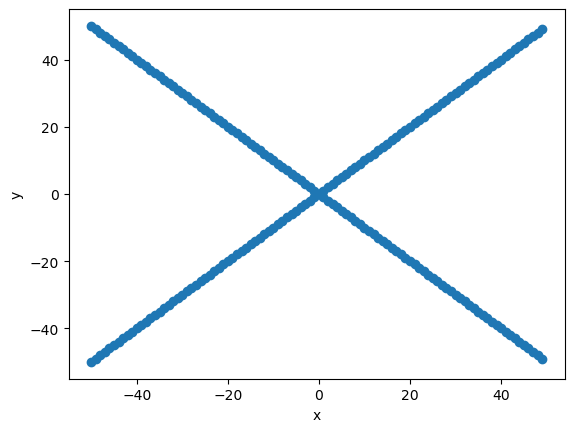

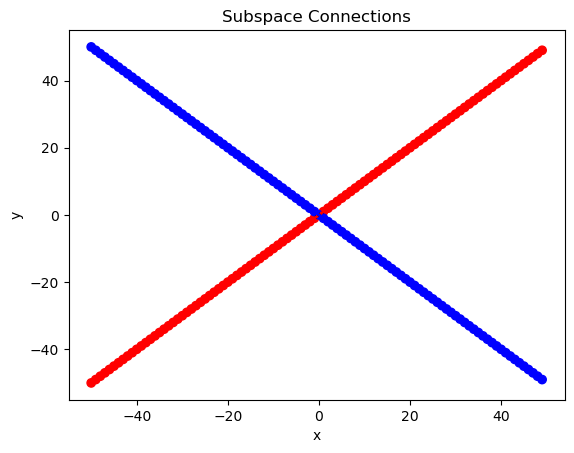

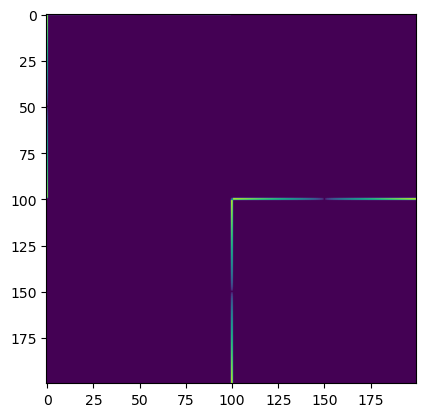

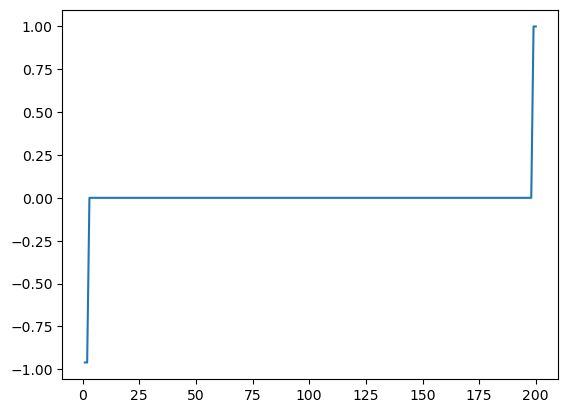

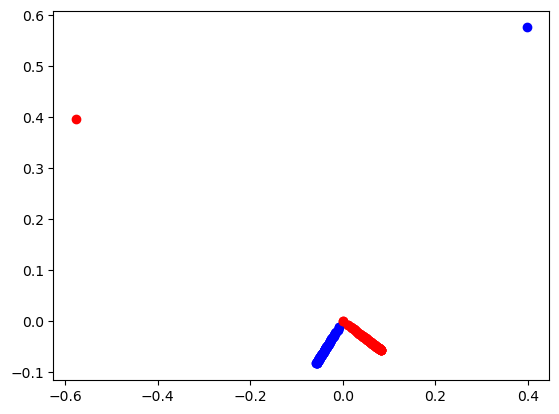

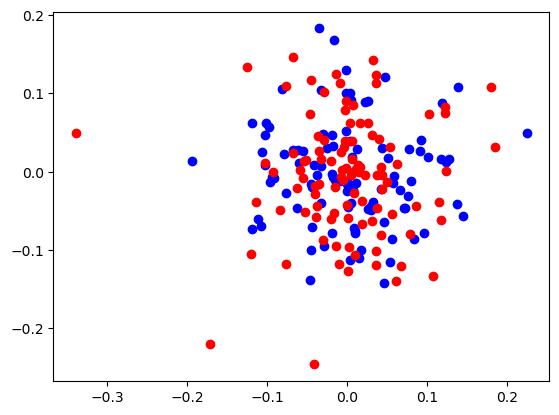

../toy_problems/10_x.tp Normalized Mutual Information Score: 96.0 %


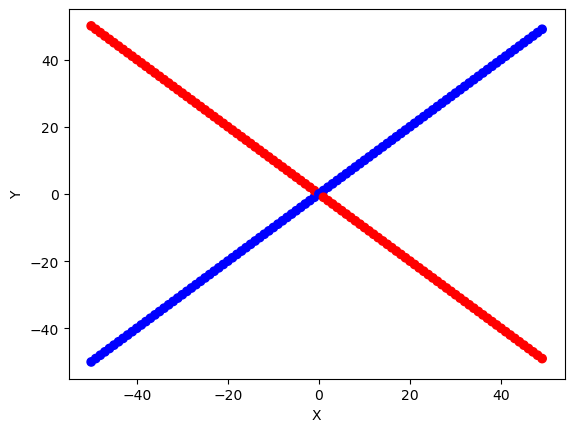

In [27]:
subspace_clustering('../toy_problems/10_x.tp', '../toy_problems/03_ground_truth.tp', 0.1, set_K=0,
                        plotter=True, printer=False)

In [29]:
for i in range(len(test)):
    subspace_clustering('../toy_problems/09_two_subset_circles.tp', '../toy_problems/03_ground_truth.tp', set_gamma=test[i], set_K=0,
                        plotter=False, printer=False)

../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.0 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 3.8 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.6 %
../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score

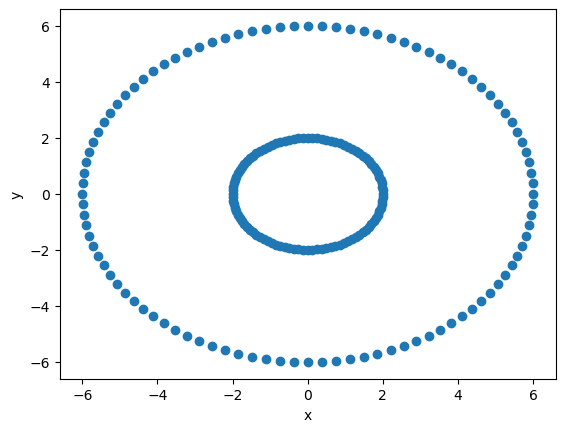

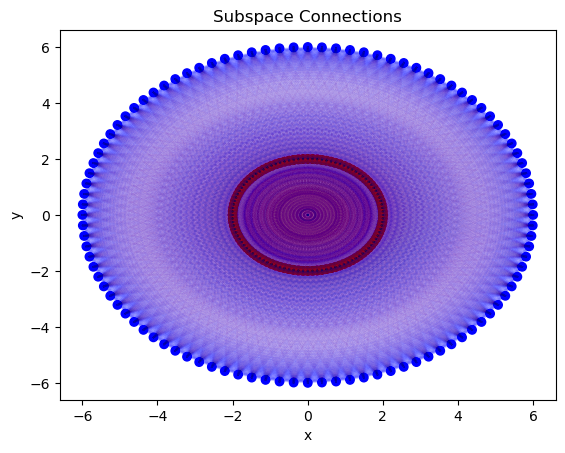

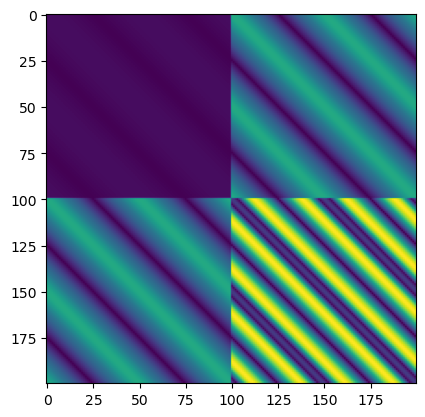

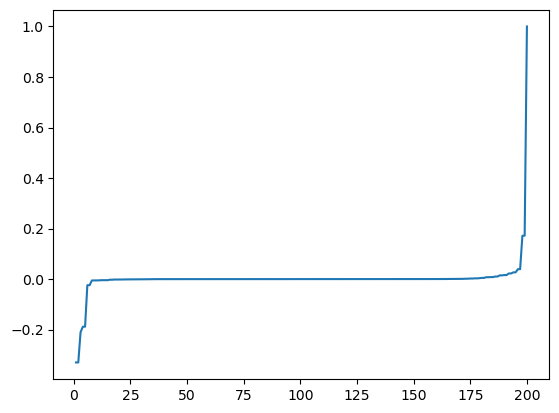

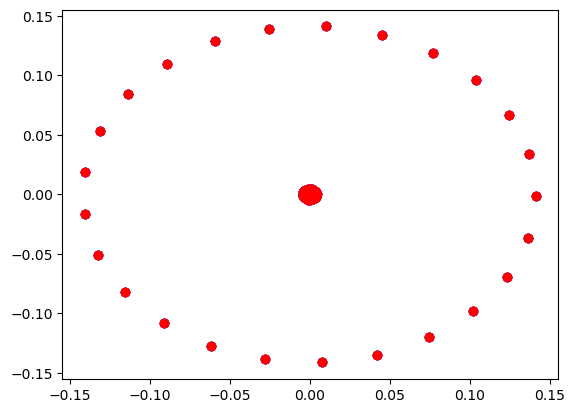

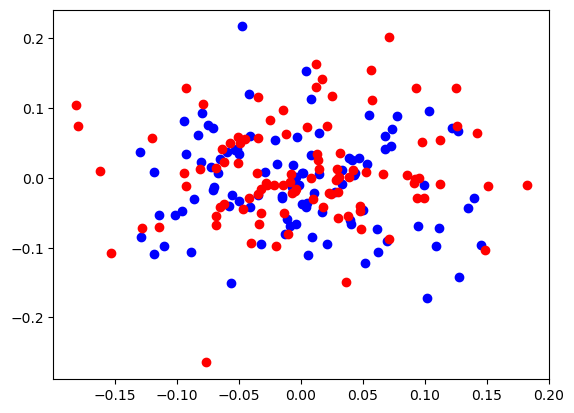

../toy_problems/09_two_subset_circles.tp Normalized Mutual Information Score: 0.0 %


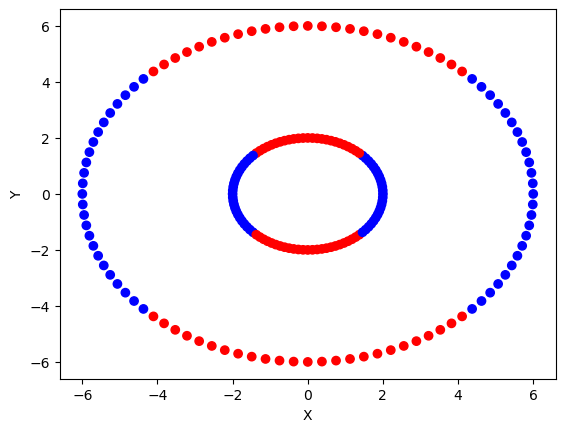

In [28]:
subspace_clustering('../toy_problems/09_two_subset_circles.tp', '../toy_problems/03_ground_truth.tp', 0.1, set_K=0,
                        plotter=True, printer=False)